# Unita: GDT

Semplice classificazione basata su Logistic Regression e Tensorflow.

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as pl
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

%matplotlib inline  

Partiamo dall'output folder dell'unità 04_notMNIST specificando dove e' posizionato il file pickle

In [2]:
pickle_file = "DeepLearning/data/notMNIST.pickle"

In [3]:
# carico i dati

with open(pickle_file, 'rb') as f:
  saved = pickle.load(f)
  train_dataset = saved['train_dataset']
  train_labels = saved['train_labels']
  valid_dataset = saved['valid_dataset']
  valid_labels = saved['valid_labels']
  test_dataset = saved['test_dataset']
  test_labels = saved['test_labels']
  del saved  # garbage collector per liberare memoria
  
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [4]:
print(train_dataset[0])
print(train_labels[0].shape)

[[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.02156863  0.17058824  0.1627451   0.16666667
   0.17450981  0.18235295  0.18627451  0.19411765  0.19803922  0.20588236
   0.20980392  0.21372549  0.22156863  0.22941177  0.22941177  0.2372549
   0.24117647  0.25686276 -0.00196078]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5         0.28431374  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.49607843  0.5
   0.21764706]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5         0.32745099  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.49607843  0.48823529  0.48823529
   0.48823529  0.48823529  0.49607843  0.5         0.5         0.5         0.5
   0.30784315]
 [-0.5        -0

In [5]:
# Riportiamo i dati nel formato adatto al processamento: matrix 1-dim + vettore 1-hot encoding

image_size = 28
num_labels = 10

def reformat(dataset, labels):
  # -1 indica che la dimensione iniziale rimane invariata
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  # aggiungo una dimensione a labels
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)


Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [6]:
print(train_dataset[0])
print(train_labels[0].shape)

[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.02156863  0.17058824  0.1627451   0.16666667
  0.17450981  0.18235295  0.18627451  0.19411765  0.19803922  0.20588236
  0.20980392  0.21372549  0.22156863  0.22941177  0.22941177  0.2372549
  0.24117647  0.25686276 -0.00196078 -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5         0.28431374
  0.5         0.5         0.5         0.5         0.5         0.5         0.5
  0.5         0.5         0.5         0.5         0.5         0.5         0.5
  0.5         0.49607843  0.5         0.21764706 -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  0.32745099  0.5         0.5         0.5         0.5         0.5         0.5
  0.5         0.49607843  0.48823529  0.48823529  0.48823529  0.48823529
  0.49607843  0.5         0.5         0.5         0.5         0.30784315
 -0.5        -0.5        -0.5

## PROBLEMA #1

Implementare una logistic regression multinomiale con discesa del gradiente con Tensorflow (TF) 
come classificatore per notMNIST.

La matrice dei pensi W viene spesso inizializzata con una variabile casuale con distribuzione normale,
dove i valori maggiori di 2 x std_dev sono rimossi.

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,   2067.,   3007.,
          3463.,   4080.,   4571.,   5182.,   5923.,   6924.,   7495.,
          8371.,   9152.,  10146.,  10889.,  11724.,  12775.,  13419.,
         14467.,  15088.,  15929.,  16350.,  16760.,  17140.,  17351.,
         17841.,  17633.,  17573.,  16917.,  16777.,  16161.,  15784.,
         15125.,  14319.,  13644.,  12665.,  11911.,  11088.,  10090.,
          9225.,   8395.,   7388.,   6877.,   6025.,   5225.,   4600.,
          3956.,   3469.,   2994.,   2045.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

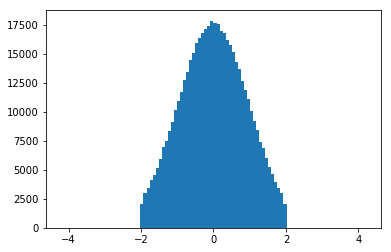

In [7]:
# weights = tf.Variable( tf.truncated_normal(...))

# Questo permette di ignorare valori troppo grandi o piccoli che possono influenzare negativamente l'apprendimento.

n = 500000
A = tf.truncated_normal((n,))
B = tf.random_normal((n,))
with tf.Session() as sess:
    a, b = sess.run([A, B])

pl.hist(a, 100, (-4.2, 4.2))

(array([  6.00000000e+00,   4.00000000e+00,   9.00000000e+00,
          1.00000000e+01,   1.30000000e+01,   2.50000000e+01,
          2.00000000e+01,   2.60000000e+01,   3.70000000e+01,
          4.60000000e+01,   6.30000000e+01,   1.01000000e+02,
          1.03000000e+02,   1.39000000e+02,   2.00000000e+02,
          2.52000000e+02,   3.33000000e+02,   4.03000000e+02,
          5.07000000e+02,   6.56000000e+02,   7.66000000e+02,
          9.17000000e+02,   1.19200000e+03,   1.38100000e+03,
          1.64400000e+03,   1.95300000e+03,   2.39200000e+03,
          2.82500000e+03,   3.30200000e+03,   3.81000000e+03,
          4.34000000e+03,   4.92700000e+03,   5.68000000e+03,
          6.46700000e+03,   7.10100000e+03,   8.00200000e+03,
          8.75000000e+03,   9.55100000e+03,   1.04740000e+04,
          1.15010000e+04,   1.21800000e+04,   1.28530000e+04,
          1.37720000e+04,   1.45120000e+04,   1.51930000e+04,
          1.57310000e+04,   1.60560000e+04,   1.62740000e+04,
        

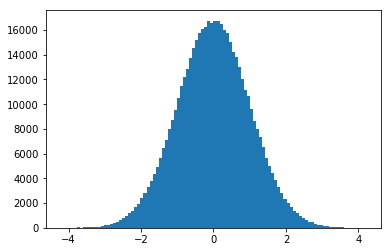

In [8]:
pl.hist(b, 100, (-4.2, 4.2))

In [9]:
# Prendiamo un subset per limitare il tempo per l'addetramento, diminuiscilo se occorre

train_subset = 10000

Su Tensorflow ogni elemento - input, variabili ed elaborazioni - è descritto mediante un grafo, o dataflow graph. Gli oggetti tf.Operation rappresentano unità di computazione;

Gli oggetti tf.Tensor rappresentano unità di dati (tensori) che sono usati come input e output per gli oggetti Operation.

In TF un grafo tf.Graph contiene due tipi di informazione:

· La struttura: nodi e archi che rappresentano le operazioni 

· Le collections: insiemi di metadati (inseriti con tf.add_to_collection) nella forma <chiave,lista di objects); si può ispezionare con tf.get_collection.

TF usa questa struttura per salvare variabili e altre informazioni del grafo.

Un oggetto Graph di default è sempre prensente e accedibile chiamando tf.get_default_graph. 

Un approccio alternativo per usare i grafo di Tensorflow consiste nel context manager tf.Graph.as_default, che sostituisce il grafo di default per tutta l'esistenza del contesto in esame.

In [10]:
graph = tf.Graph()

# Costruisco un grafo di computazione con Tensorflow
with graph.as_default():

  # Creo tensori costanti per i seguenti set: trainig, test e validation
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  # per assegnare un nome alla variabile possiamo usare il secondo parametro, e.g., tf.constant(0, name="c") 
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Le variabili mantengono lo stato durante le elaborazioni. Sono anch'esse tensori.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  # Il vettore di bias b e' inizializzato a 0.
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Calcolo Wx + b
  logits = tf.matmul(tf_train_dataset, weights) + biases

  # La funzione softmax_cross_entropy_with_logits valuta la funzione di loss
  # per mezzo della cross-entropy loss con l'output corretto (tf_train_labels)
  # Mentre reduce_mean valuta semplicemente la media dei valori del tensore.
  # loss indica una operazione TF.
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Instanzio un algoritmo di discesa del gradiente con learning rate = 0.5 (alfa nelle slide di richiami sulle reti neurali.)
  # La funzione minimize e' composta di 2 elaborazioni: compute_gradients e apply_gradients.
  # La prima ricava i gradienti, la seconda aggiorna la matrice dei pesi di conseguenza.
  # optimizer indica una operazione TF.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
  # calcolo softmax = tf.exp(logits) / tf.reduce_sum(tf.exp(logits), dim) per i sets: 
  # training, validation e test.
  # N.B.: i set valid e test sono usati solo per la valutazione, non c'e' backprop
  # N.B.(2): ci servono per valutare l'accuratezza, l'apprendimento l'abbiamo gia' fatto.
  train_prediction = tf.nn.softmax(logits)
  logits = tf.matmul(tf_valid_dataset, weights) + biases
  
  valid_prediction = tf.nn.softmax(logits) 
  logits = tf.matmul(tf_valid_dataset, weights) + biases
                     
  test_prediction = tf.nn.softmax(logits)


In [11]:
# numero cicli di elaborazione
num_steps = 801

Definisco l'accuratezza come somma del numero di predizioni corrette normalizzato sul numero di predizioni totali.

La uso per fare statistiche durante il funzionamento.

In [12]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

# TF usa tf.Session per rappresentare una connesione tra il programa e il runtime C++.
# Serve per creare un ambiente in cui lanciare le operazioni definite nel grafo.
# Poiche' la classe alloca risorse fisiche, solitamente si usa come context manager (dentro un blocco with),
# che le libera automaticamente al termine del blocco, cioe' lancia session.close() al termine della esecuzione.
with tf.Session(graph=graph) as session:
  
  # Istanzia e lancia una operazione per l'inizializzazione delle variabili globali del grafo
  # cioe': weights e biases. Va eseguita solo una volta.
  tf.global_variables_initializer().run()
  print('Initialized')
      
  for step in range(num_steps):
    
    # Eseguo le operazioni nel grafo.
    # Le operazioni e i tensori da valutare sono definiti nel primo parametro, un NumPy array.
    # La lista indica le foglie grafo.
    # Il valore di ritorno ha lo stesso tipo dell'input, cioe' un array, 
    # dove le foglie sono sostituite con il corrispondente valore calcolato da TF.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    
    # ogni tanto stampo statistiche
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))
      
      # Se invoco eval() su valid_prediction, sto calcolando l'operazione sui 
      # pesi e bias correnti.
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  
  # Al termine stamo l'accuracy sul test set.
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))


Initialized


Loss at step 0: 16.904888
Training accuracy: 12.6%
Validation accuracy: 15.2%


Loss at step 100: 2.367931
Training accuracy: 71.1%
Validation accuracy: 70.6%


Loss at step 200: 1.895879
Training accuracy: 74.2%
Validation accuracy: 73.0%


Loss at step 300: 1.631782
Training accuracy: 75.7%
Validation accuracy: 73.8%


Loss at step 400: 1.454509
Training accuracy: 76.6%
Validation accuracy: 74.3%


Loss at step 500: 1.324679
Training accuracy: 77.3%
Validation accuracy: 74.7%


Loss at step 600: 1.224638
Training accuracy: 77.8%
Validation accuracy: 74.9%


Loss at step 700: 1.144739
Training accuracy: 78.1%
Validation accuracy: 75.0%


Loss at step 800: 1.079199
Training accuracy: 78.7%
Validation accuracy: 75.2%


Test accuracy: 10.1%


## PROBLEMA #2
 
Prova a modificare il codice precedente impiegando un Stochastic gradient descent.

Quanto tempo impiega ora per terminare l'elaborazione?

Durante l'elaborazone batch l'algoritmo elabora solo un sottoinsieme di dati alla volta.

L'elaborazione è ripetuta, perciò conviene scrivere il codice senza gestire la creazione dei dati direttamente.

In TF un placeholder è una variabile che assumera i valori a tempo di esecuzione.

Possiamo costruire il grafo delle operazioni senza il bisogno di conoscere i dati.

In [13]:
# Nel seguente codice creiamo una operazione (y) di moltiplicazione * 2 senza sapere i valori.
# Ora la possiamo eseguire all'interno di una sessione. Per valutarla occorre fornire (feed)
# i valori per x. 
# None significa che non poniamo vincoli sulla dimensione.
x = tf.placeholder(tf.float32, shape=None)
y = x * 2

# TF supporta tipi di variabili simili a NumPy (es. float32, float64, int32, int64)
# https://docs.scipy.org/doc/numpy-1.13.0/user/basics.types.html

with tf.Session() as session:
    result = session.run(y, feed_dict={x: [1, 2, 3]})
    print(result)


[ 2.  4.  6.]


N.B. Fuori dallo scope session non possiamo stampare il valore dei tensori durante l'elaborazione.

#### x = tf.placeholder("float", None)
#### y = x * 2
#### print(x) 

#### Output: "Tensor("Placeholder_11:0", dtype=float32)" 

Stampa solo il tipo e non il valore di x.
In alternativa usare https://www.tensorflow.org/api_docs/python/tf/InteractiveSession

In [14]:
# Possiamo dare in input anche strutture piu' complesse indicando il formato dei dati con shape.
# Es. un qualsiasi numero di righe, ma il numero di colonne pari a 3
x = tf.placeholder(tf.float32, shape=[None, 3])
y = x * 2

with tf.Session() as session:
    x_data = [[1, 2, 3],
              [4, 5, 6],]
    result = session.run(y, feed_dict={x: x_data})
    print(result)

[[  2.   4.   6.]
 [  8.  10.  12.]]


Una immagine a colori (RGB) in formato raw può avere una rappresentazione matriciale

#### image = tf.placeholder("uint8", shape=[None, None, 3])

In [15]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Una operazione placeholder viene usata per alimentare il grafo.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))

  # Il resto è uguale al precedente esempio.
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  train_prediction = tf.nn.softmax(logits)
  logits = tf.matmul(tf_valid_dataset, weights) + biases
  valid_prediction = tf.nn.softmax(logits) 
  logits = tf.matmul(tf_test_dataset, weights) + biases
  test_prediction = tf.nn.softmax(logits)

In [16]:
# Se impiego minibatch potenzialmente ho più varianza nell'apprendimento ad ogni ciclo.
# Sono costretto ad aumentare gli step.
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
    
  for step in range(num_steps):
    # Definisco un offset nel trainig set
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    
    # Estraggo ilminibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]

    # Dizionario {chiave_placeholder : valore, ...}
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
    
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 15.735717
Minibatch accuracy: 13.3%
Validation accuracy: 15.4%


Minibatch loss at step 500: 1.864795
Minibatch accuracy: 75.8%
Validation accuracy: 75.8%


Minibatch loss at step 1000: 1.584352
Minibatch accuracy: 73.4%
Validation accuracy: 76.8%


Minibatch loss at step 1500: 1.361099
Minibatch accuracy: 75.8%
Validation accuracy: 76.7%


Minibatch loss at step 2000: 1.038256
Minibatch accuracy: 79.7%
Validation accuracy: 77.5%


Minibatch loss at step 2500: 0.977711
Minibatch accuracy: 75.0%
Validation accuracy: 78.2%


Minibatch loss at step 3000: 1.129219
Minibatch accuracy: 78.1%
Validation accuracy: 78.8%


Test accuracy: 86.1%


# L'accuratezza sul minibatch diminuisce mentre quella sulla validation aumenta.

## PROBLEMA #3

Usando l'help online di TF prova a creare una rete neurale con 1-hidden layer con attivazione RELU e 1024 nodi nascosti.

N.B. la funzione tf.nn.relu() restituisce un tensore che calcola la RELU sul tensore di input.

L'output ha la stessa dimensione dell'input.

In [17]:
# nodi del hidden layer
hidden_nodes= 1024
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Avendo un layer in più ho due coppie <W,B>
    # N.B. W1 e B1 hanno dimensioni <#input-feature-vector,#hidden-nodes>, <#hidden-nodes>
    # mentre W2 <#hidden-nodes,num_labels>, <num_labels>
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes]))
    biases_1 = tf.Variable(tf.zeros([hidden_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))

    
    logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2

    # Ora la loss function è definita sullo layer di output
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits \
                          (labels=tf_train_labels, logits=logits_2))

    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits_2)
    # Seguo la stessa pipeline per valid e test set
    logits_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    valid_prediction = tf.nn.softmax(logits_2) 
    
    logits_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    test_prediction = tf.nn.softmax(logits_2)

In [18]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
    
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
    
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 418.583008
Minibatch accuracy: 8.6%


Validation accuracy: 33.0%


Minibatch loss at step 500: 16.843128
Minibatch accuracy: 77.3%


Validation accuracy: 80.6%


Minibatch loss at step 1000: 26.599648
Minibatch accuracy: 78.9%


Validation accuracy: 79.5%


Minibatch loss at step 1500: 8.241529
Minibatch accuracy: 75.8%


Validation accuracy: 81.0%


Minibatch loss at step 2000: 6.842561
Minibatch accuracy: 85.9%


Validation accuracy: 81.2%


Minibatch loss at step 2500: 4.103213
Minibatch accuracy: 80.5%


Validation accuracy: 82.4%


Minibatch loss at step 3000: 3.539648
Minibatch accuracy: 80.5%


Validation accuracy: 81.6%


Test accuracy: 88.7%


# L'accuratezza sul minibatch diminuisce mentre quella sulla validation aumenta molto più rapidamente.